# Comparison between observations and sea level projections

- Compare trends computed with OLS instead of from comparing the difference between two periods
- Compare time series of individual contributors
- Compare multiple versions of KNMI'23

In [1]:
import sys
import importlib

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import linregress

Projects_dir = '/Users/dewilebars/Projects/'
ProbSLR_dir = f'{Projects_dir}Project_ProbSLR/SLProj/'

sys.path.append(f'{Projects_dir}SLBudget/code/')
import SeaLevelContrib as slc
sys.path.append(f'{ProbSLR_dir}code/')
import func_postpro as postpro

In [2]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [140]:
importlib.reload(slc)
importlib.reload(postpro)

<module 'func_postpro' from '/Users/dewilebars/Projects/Project_ProbSLR/SLProj/code/func_postpro.py'>

In [4]:
path_fig = '.'

In [180]:
# Specify colors
rgb_red = '#d52b1e'
rgb_orange = '#f68e64'
rgb_yellow = '#fec35e'

## Read budget data

In [67]:
# Local sea level budget
path_slb = f'{Projects_dir}SLBudget/outputs/'

budget_tg_df = pd.read_csv(path_slb+
                        'slbudget_2022_11_23_ZSM_tide_gauge_1950_2021_ERA5_StericEN4_22_[500, 4000]m.csv')

budget_alti_df = pd.read_csv(path_slb+
                        'slbudget_2022_12_01_NL_region_altimetry_1993_2021_ERA5_StericEN4_22_[500, 4000]m.csv')

budget_tg_df.set_index('time', inplace=True)
budget_alti_df.set_index('time', inplace=True)

# Change the index the center on the years
budget_tg_df.index = budget_tg_df.index + 0.5
budget_alti_df.index = budget_alti_df.index + 0.5

budget_tg_df


,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
1950.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.580712
1951.5,-5.780009,-3.665236,0.097124,0.036833,0.054167,0.004167,0.006667,0.360000,0.007106,-3.187448,0.506611,1.047379
1952.5,-2.983398,-2.856293,0.176444,0.073667,0.115833,0.010000,0.011667,0.333333,-0.046784,-0.669538,-0.131727,3.480712
1953.5,-3.471756,-0.499573,0.177486,0.110500,0.186667,0.014167,0.017500,0.296667,-0.155587,-1.477534,-2.142049,-0.419288
1954.5,3.989206,-0.021989,0.193522,0.147333,0.242500,0.019167,0.020000,0.148333,-0.307016,3.340130,0.207225,2.347379
...,...,...,...,...,...,...,...,...,...,...,...,...
2017.5,12.027647,1.650100,4.838131,2.467833,2.657500,0.850833,0.269167,-0.684167,-1.030123,1.930466,-0.922094,18.114046
2018.5,6.309250,1.168228,4.889651,2.504667,2.677500,0.959167,0.276667,-0.811667,-0.928142,-3.614668,-0.812152,10.830712
2019.5,11.140404,2.074197,5.082026,2.541500,2.725333,0.990444,0.286778,-0.516500,-0.781557,-1.051020,-0.210798,17.814046


In [71]:
# Read global data as well

glo_df = pd.read_csv(f'{path_slb}Frederikse2020_global_extrap.csv')
glo_df.set_index('time', inplace=True)

# Shift index
glo_df.index = glo_df.index+0.5

glo_df

,Glaciers [mean],Greenland Ice Sheet [mean],Antarctic Ice Sheet [mean],Terrestrial Water Storage [mean]
time,,,,
1900.5,-7.955370,-4.806443,-0.949485,1.232683
1901.5,-7.870381,-4.817939,-0.944032,1.524670
1902.5,-7.784364,-4.786170,-0.938561,1.657081
1903.5,-7.727209,-4.745355,-0.933183,1.662429
1904.5,-7.643074,-4.662656,-0.927764,1.622705
...,...,...,...,...
2017.5,0.498592,0.583257,0.265242,0.275522
2018.5,0.527204,0.596942,0.381002,0.200524
2019.5,0.611342,0.751810,0.416762,0.413428


## Print comparison global and local sea level contributors

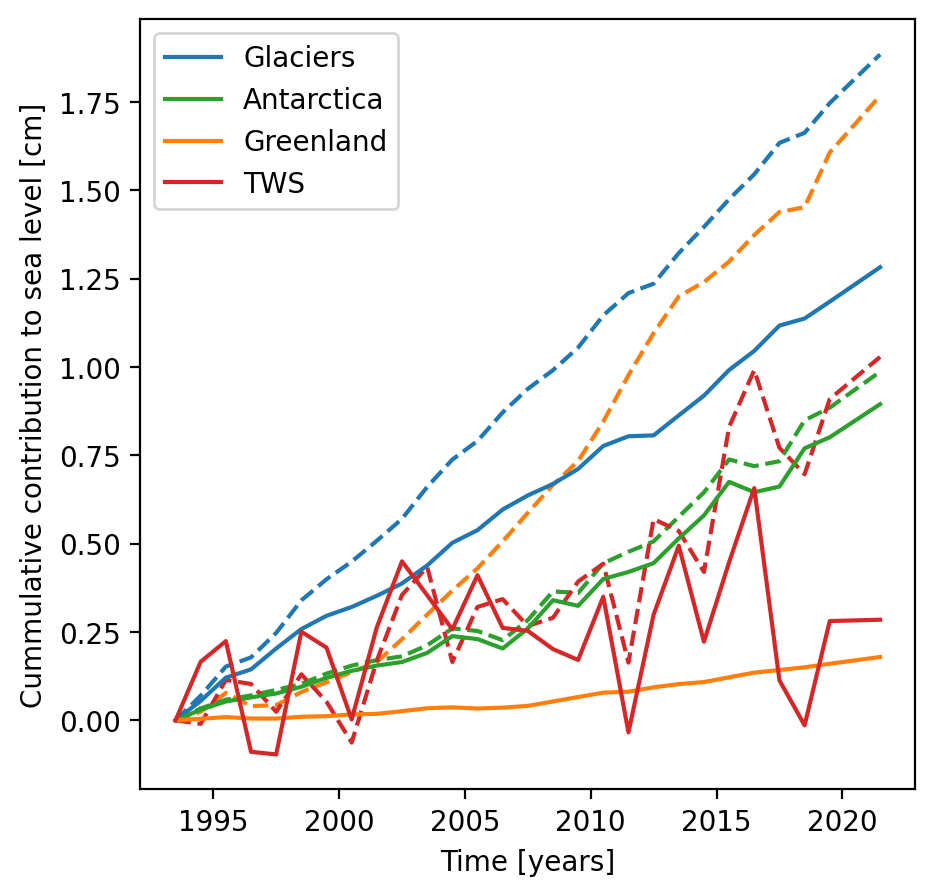

In [94]:
fig, ax = plt.subplots(figsize=(5,5))


glo_df2 = glo_df.loc[1993.5:]
glo_df2 = glo_df2-glo_df2.loc[1993.5]

budget_tg_df2 = budget_tg_df.loc[1993.5:,['Glaciers', 'Antarctica', 'Greenland', 'TWS']]
budget_tg_df2 = budget_tg_df2-budget_tg_df2.loc[1993.5]

glo_df2.plot(ax=ax, legend=None, linestyle='dashed')
budget_tg_df2.plot(ax=ax, color=['tab:blue', 'tab:green', 'tab:orange', 'tab:red'])

plt.xlabel('Time [years]')
plt.ylabel('Cummulative contribution to sea level [cm]')

plt.savefig('./figures/CompObs_GloLoc.pdf', dpi=150)

## Read scenario data

### KNMI14

In [197]:
# Standard KNMI14 csv data file
subs_knmi14 = 0.037 # cm/yr
KNMI14_df = postpro.read_knmi14(add_subsidence=subs_knmi14, polyfit=True)
KNMI14_df[:5]

,low_05,low_95,high_05,high_95,low_05_sub,low_95_sub,high_05_sub,high_95_sub
year,,,,,,,,
1995,0.2,0.8,-0.1,0.5,0.200,0.800,-0.100,0.500
1996,0.4,1.2,0.2,1.0,0.445,1.245,0.245,1.045
1997,0.5,1.6,0.5,1.5,0.590,1.690,0.590,1.590
1998,0.7,2.0,0.7,2.1,0.835,2.135,0.835,2.235
1999,0.8,2.4,1.0,2.6,0.980,2.580,1.180,2.780


In [198]:
# KNMI14 projections including components info
# Info on the "level" index: 
# mean, p05, p10, p50, p90, p95, last column not used.
path_KNMI14 = '/Users/dewilebars/Projects/Project_ProbSLR/KNMI14/'
KNMI14_high_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_high_V8.nc', 
                                 decode_times=False)
KNMI14_low_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_low_V8.nc', 
                                decode_times=False)
KNMI14_high_ds['time'] = KNMI14_high_ds.time + 1950
KNMI14_low_ds['time'] = KNMI14_low_ds.time + 1950

In [199]:
def KNMI14_ds2df(ds,level=3):
    '''Extract the time series of contributors from a sea level projection 
    xarray dataset and build a pandas dataframe. Inputs are a dataset and 
    the percentile to extract.
    Info on the "level" index: 
    0:mean, 1:p05, 2:p10, 3:p50, 4:p90, 5:p95, 6:not used.
    '''
    variables = ['total', 'smb_gre', 'smb_aa', 'gic', 'ibe', 'steric', 
                 'dyn_gre', 'dyn_aa', 'groundw','tglob']
    
    df = pd.DataFrame()
    for val in variables:
        if val == 'tglob':
            df[val] = ds[val][:,0,0,0]
        else:
            df[val] = ds[val][:,level,0,0]*100 # Convert from m to cm

    # Center the years
    df['time'] = ds.time + 0.5
    df = df.set_index('time')
    
    return df

KNMI14_high_df = KNMI14_ds2df(KNMI14_high_ds, 0)
KNMI14_low_df = KNMI14_ds2df(KNMI14_low_ds, 0)

In [163]:
KNMI14_low_df

,total,smb_gre,smb_aa,gic,ibe,steric,dyn_gre,dyn_aa,groundw,tglob
time,,,,,,,,,,
1986.5,-1.870377,0.046630,0.000000,-1.040916,0.238453,-1.023174,-0.091369,0.000000,0.000000,-0.100000
1987.5,-2.291256,0.046623,0.000000,-0.776771,-0.197886,-0.947712,-0.087446,0.000000,-0.328063,-0.088889
1988.5,-1.834952,0.046630,0.000000,-0.759642,-0.064240,-0.601879,-0.083429,0.000000,-0.372392,-0.077778
1989.5,-1.728449,0.046610,0.000000,-0.692082,-0.053985,-0.569760,-0.079318,0.000000,-0.379913,-0.066667
1990.5,-2.016908,0.046608,0.000000,-0.665228,-0.001086,-0.949826,-0.075113,0.000000,-0.372263,-0.055556
...,...,...,...,...,...,...,...,...,...,...
2096.5,45.356621,0.492812,-2.680037,7.818039,-0.344517,25.670403,0.759792,10.354333,3.285792,1.573333
2097.5,45.747551,0.500576,-2.728119,7.906240,-0.322754,25.764605,0.771340,10.525579,3.330083,1.580000
2098.5,46.329910,0.503922,-2.763131,7.971743,-0.202447,25.967009,0.782982,10.698524,3.371308,1.586667


### Klimaatsignaal'21

In [10]:
def read_proj(sce, name):
    '''Read projection data and add subsidence'''
    
    if name == 'KNMI14':
        proj_data_dir = f'{ProbSLR_dir}/outputs/ref_proj/'
    else:
        proj_data_dir = f'{ProbSLR_dir}/outputs/KNMIsignal_v3/'
        
    proj_ds = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_{name}_{sce}.nc')
    subsidence = (np.arange(len(proj_ds.time))+10) * 0.045
    sub_2d = np.repeat(subsidence[:,np.newaxis], 
                       repeats=len(proj_ds.percentiles), axis=1)
    sub_2d = np.swapaxes(sub_2d,0,1)
    tot_sub = sub_2d+proj_ds.perc_ts.sel(proc='Total').values
    sub = np.concatenate([sub_2d[np.newaxis,:,:],  tot_sub[np.newaxis,:,:]],
                         axis=0)
    proj_sub = xr.DataArray(sub, dims=proj_ds.perc_ts.dims, 
                            coords=[['Subsidence', 'Total_with_sub'], 
                                    proj_ds.percentiles, proj_ds.time])
    proj_sub = xr.concat([proj_ds.perc_ts, proj_sub], dim='proc')
    
    return proj_sub


In [11]:
KNMIsig_ssp245 = read_proj('ssp245', 'KNMIsignal_BiasCorr_NoWind')
KNMIsig_ssp585 = read_proj('ssp585', 'KNMIsignal_BiasCorr_NoWind')

### KNMI'23

In [12]:
proj_data_dir = f'{ProbSLR_dir}/outputs/KNMI23/'

KNMI23_ssp126 = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_KNMI23_ssp126_v19.nc')
KNMI23_ssp245 = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_KNMI23_ssp245_v19.nc')
KNMI23_ssp585 = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_KNMI23_ssp585_v19.nc')

KNMI23_ssp126 = KNMI23_ssp126.perc_ts
KNMI23_ssp245 = KNMI23_ssp245.perc_ts
KNMI23_ssp585 = KNMI23_ssp585.perc_ts

# KNMI23 v1 is the same as Klimaatsignaal'21 with extended data back to 1995 
#and mean in the outputs

KNMI23_ssp245_v1 = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_KNMI23_ssp245_v1.nc')
KNMI23_ssp585_v1 = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_KNMI23_ssp585_v1.nc')

KNMI23_ssp245_v1 = KNMI23_ssp245_v1.perc_ts
KNMI23_ssp585_v1 = KNMI23_ssp585_v1.perc_ts

In [13]:
def KNMI23_ds2df(ds, perc):
    '''Extract the time series of contributors from a sea level projection 
    xarray dataset and build a pandas dataframe. Inputs are a dataset and 
    the percentile to extract.
    '''
    
    df = pd.DataFrame()
    
    for val in ds.proc:
        df[val.item()] = ds.sel(proc=val, percentiles=perc)

    df['time'] = ds.time
    df = df.set_index('time')
    
    return df

In [14]:
KNMI23_ssp245_df = KNMI23_ds2df(KNMI23_ssp245, 'mean')
KNMI23_ssp585_df = KNMI23_ds2df(KNMI23_ssp585, 'mean')

KNMI23_ssp245_v1_df = KNMI23_ds2df(KNMI23_ssp245_v1, 'mean')
KNMI23_ssp585_v1_df = KNMI23_ds2df(KNMI23_ssp585_v1, 'mean')

In [15]:
KNMI23_ssp245_df

,Global steric,Ocean Dynamic Sea Level,Inverse barometer,Glaciers,Greenland SMB,Antarctic SMB,Landwater,Antarctic dynamics,Greenland dynamics,Greenland,Antarctica,GIA,Total
time,,,,,,,,,,,,,
1995.5,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
1996.5,0.091156,0.059691,0.0,0.051927,0.003003,-0.000726,0.000000,0.050549,0.003012,0.006014,0.049823,0.037,0.286074
1997.5,0.182312,0.119382,0.0,0.103853,0.006005,-0.001452,0.000000,0.101098,0.006024,0.012029,0.099646,0.074,0.572147
1998.5,0.273467,0.179073,0.0,0.155780,0.009008,-0.002178,0.000000,0.151647,0.009035,0.018043,0.149469,0.111,0.858221
1999.5,0.364623,0.238765,0.0,0.207706,0.012011,-0.002904,0.000000,0.202196,0.012047,0.024058,0.199291,0.148,1.144295
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096.5,20.720981,13.673848,0.0,7.566716,0.998451,-3.686661,1.719682,18.329836,0.837517,1.835967,14.643175,3.737,62.888736
2097.5,20.960497,13.728621,0.0,7.658736,1.017775,-3.752137,1.757841,18.697425,0.848848,1.866624,14.945287,3.774,63.674060
2098.5,21.198758,13.778544,0.0,7.750526,1.037191,-3.817824,1.749736,19.050850,0.860233,1.897423,15.233026,3.811,64.392614


## Comparison plots

### Compare different observations

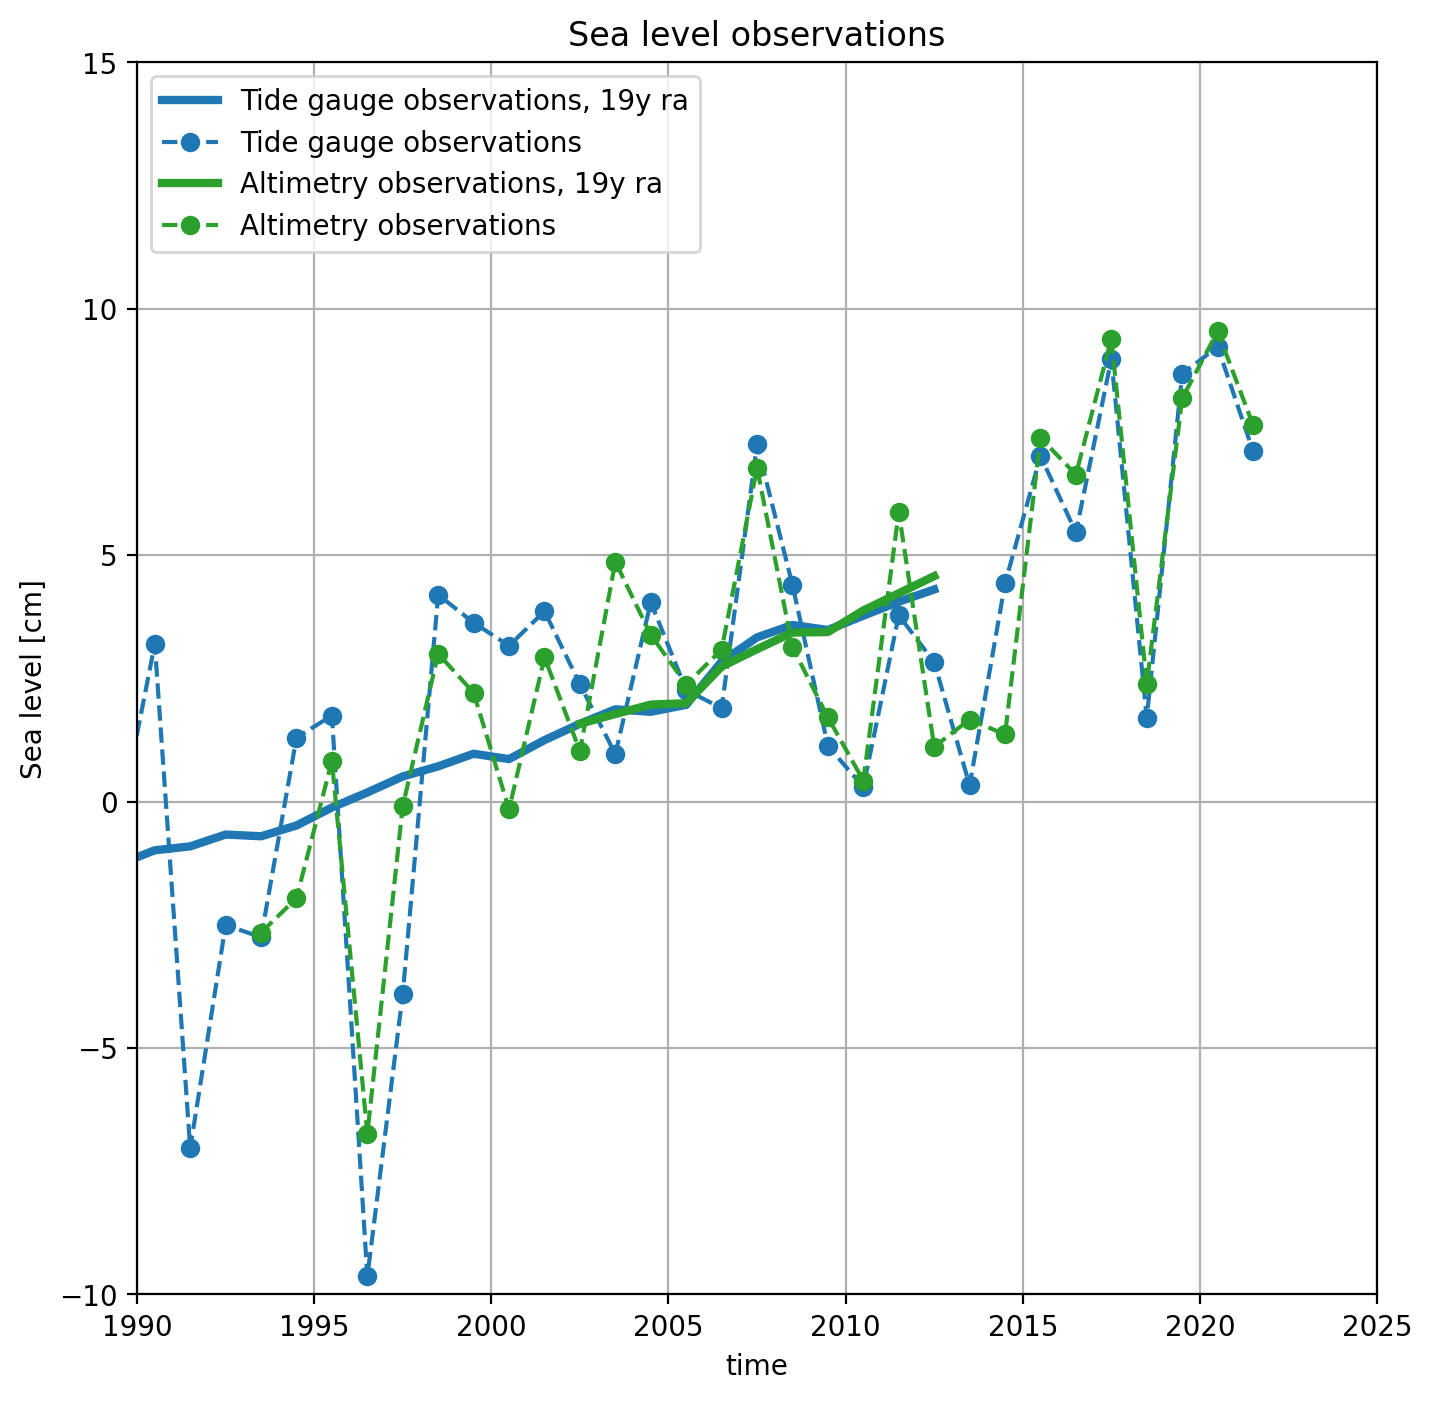

In [174]:
tg_19ra = budget_tg_df['Obs'].rolling(19, center=True).mean()
alti_19ra = budget_alti_df['Obs'].rolling(19, center=True).mean()

#ref = tg_19ra.loc[1995.5]
ref = budget_tg_df['Obs'].loc[1986:2006].mean()
ref_alti = alti_19ra.loc[2002.5]-tg_19ra.loc[2002.5]+ref

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(tg_19ra - ref, '-', color='tab:blue', label='Tide gauge observations, 19y ra', linewidth=3)
ax.plot(budget_tg_df['Obs'] - ref, 'o--', color='tab:blue', label='Tide gauge observations')
ax.plot(alti_19ra - ref_alti, '-', color='tab:green', label='Altimetry observations, 19y ra', linewidth=3)
ax.plot(budget_alti_df['Obs'] - ref_alti, 'o--', color='tab:green', label='Altimetry observations')


#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('time')
plt.ylabel('Sea level [cm]')
plt.title('Sea level observations')
ax.grid(True)
plt.legend(loc='upper left')

In [17]:
def linear_trend(se, acc=1):
    """Returns the linear trend and its standard error given a pandas series as input"""
    
    se = se*10 # Convert from cm to mm
    
    lin_trend = linregress(se.index, se)
    print(f'Linear trend [mm/y] for period {str(se.index[0])}-{se.index[-1]} and '+
          'standard error')
    print(f'{round(lin_trend.slope,acc)}, {round(lin_trend.stderr,acc)}')
    
    return lin_trend

In [18]:
print('Linear trend from tide gauge data:')
linear_trend(budget_tg_df['Obs'].loc[1993.5:2021.5])

print('Linear trend from altimetry data:')
linear_trend(budget_alti_df['Obs'].loc[1993.5:2021.5]);


Linear trend from tide gauge data:
Linear trend [mm/y] for period 1993.5-2021.5 and standard error
3.0, 0.7
Linear trend from altimetry data:
Linear trend [mm/y] for period 1993.5-2021.5 and standard error
3.2, 0.6


Given that tide gauges measure relative sea level while satellite altimetry measures absolute sea level we would expect that the trend from tide gauges is smaller than that from altimetry but this is not the case.

### Compare observations and scenarios

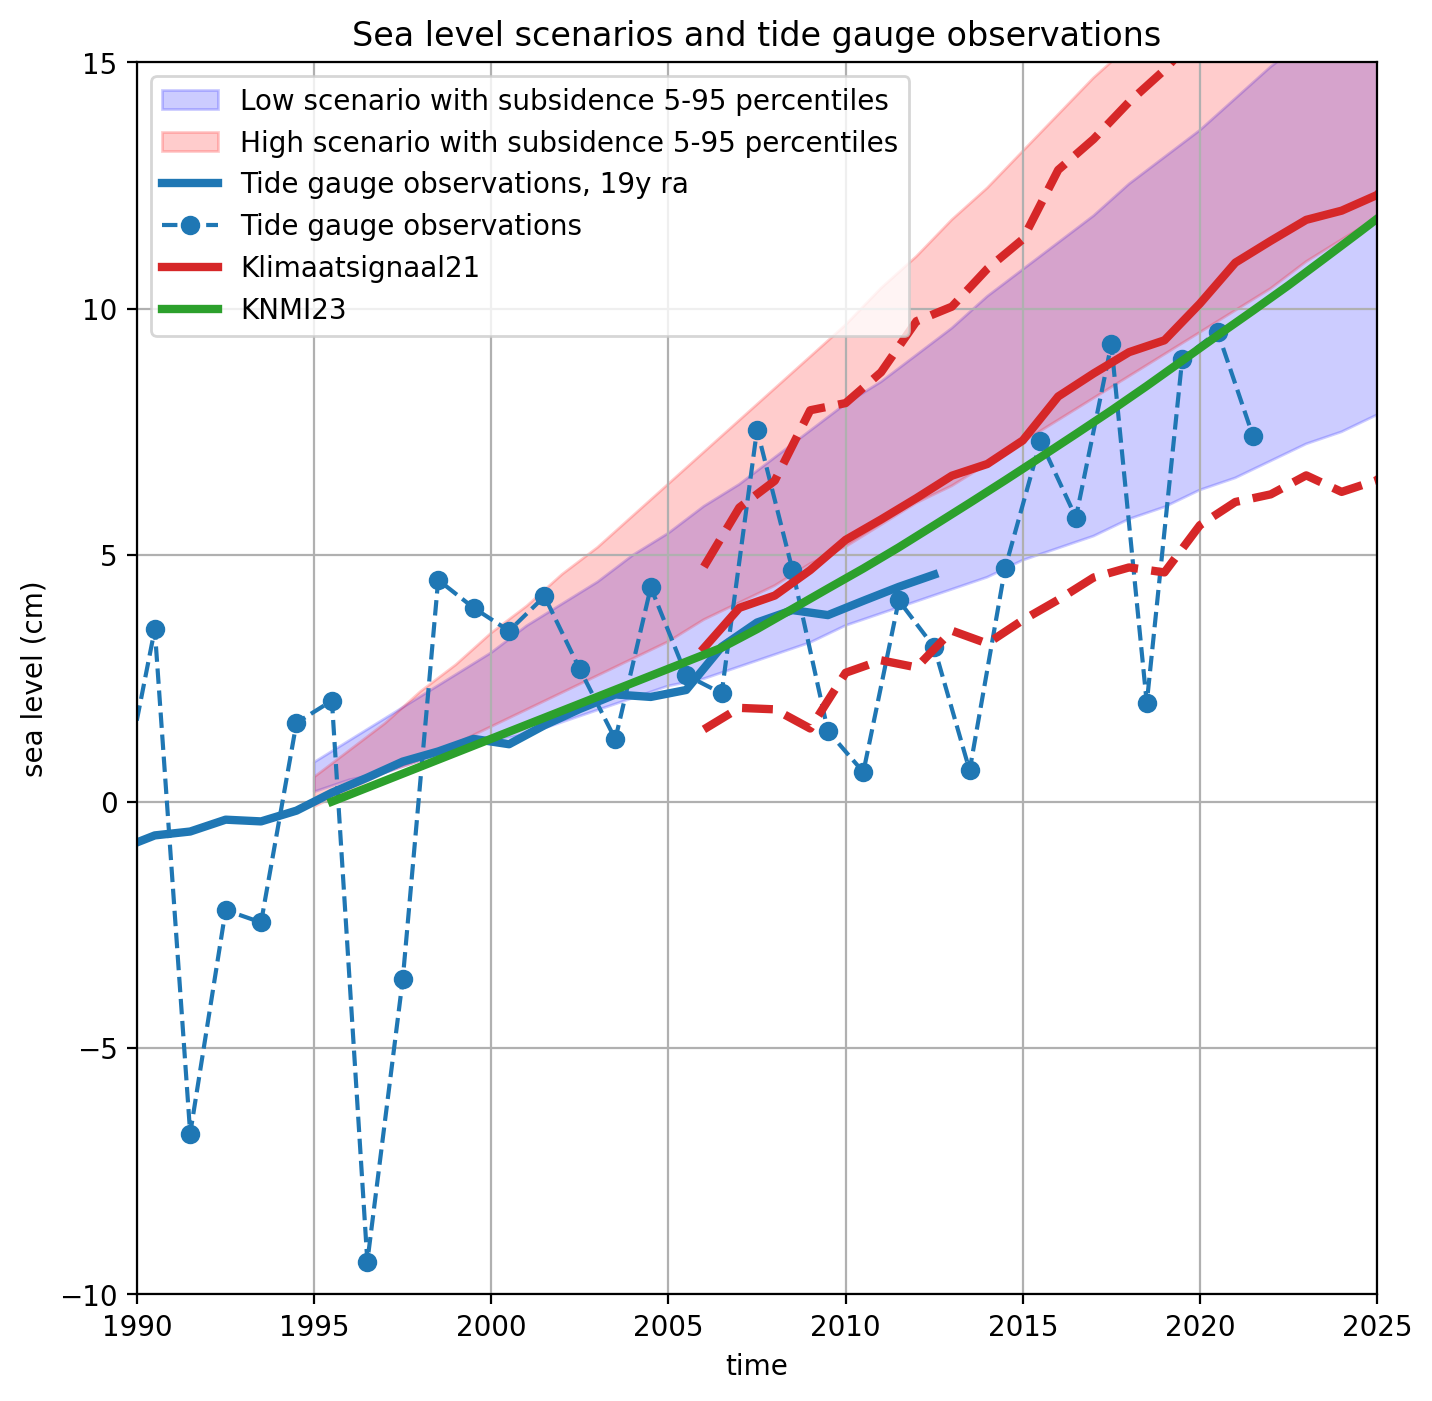

In [175]:
ref = (tg_19ra.loc[1995.5]+tg_19ra.loc[1994.5])/2

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'], 
                KNMI14_df['low_95_sub'], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'], 
                KNMI14_df['high_95_sub'], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_19ra - ref, '-', color='tab:blue', label='Tide gauge observations, 19y ra', linewidth=3)
ax.plot(budget_tg_df['Obs'] - ref, 'o--', color='tab:blue', label='Tide gauge observations')

KNMIsig_ssp245.sel(proc='Total_with_sub', percentiles=[50]).plot(color='tab:red', label='Klimaatsignaal21', linewidth=3)
KNMIsig_ssp245.sel(proc='Total_with_sub', percentiles=[5]).plot(color='tab:red', linewidth=3, linestyle='--')
KNMIsig_ssp245.sel(proc='Total_with_sub', percentiles=[95]).plot(color='tab:red', linewidth=3, linestyle='--')
                                                                 
                                                                 
KNMI23_ssp245.sel(proc='Total', percentiles=['50']).plot(color='tab:green', linestyle='-', label='KNMI23', linewidth=3)

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig('./figures/CompObsProj_KNMI14_KS21_KNMI23.pdf', dpi=150)

#### Figure KNMI23 for scientific report

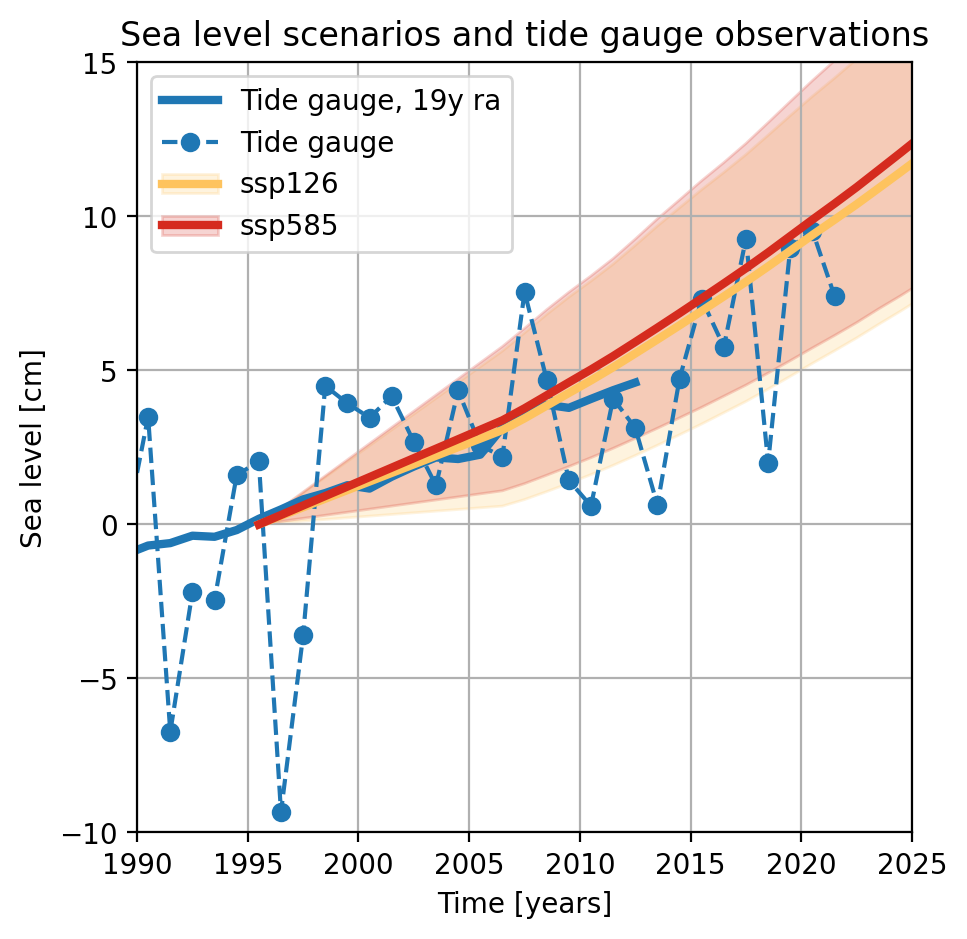

In [182]:
#Plot time series
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(tg_19ra - ref, '-', color='tab:blue', label='Tide gauge, 19y ra', linewidth=3)
ax.plot(budget_tg_df['Obs'] - ref, 'o--', color='tab:blue', label='Tide gauge')


KNMI23_ssp126.sel(proc='Total', percentiles=['50']).plot(color=rgb_yellow, linestyle='-', label='KNMI23', linewidth=3)

ax.fill_between(KNMI23_ssp126.time, 
                KNMI23_ssp126.sel(proc='Total', percentiles=['5']).data[0], 
                KNMI23_ssp126.sel(proc='Total', percentiles=['95']).data[0], 
                color=rgb_yellow, 
                alpha=0.2,
                label='ssp126')

KNMI23_ssp585.sel(proc='Total', percentiles=['50']).plot(color=rgb_red, linestyle='-', label='KNMI23', linewidth=3)

ax.fill_between(KNMI23_ssp585.time, 
                KNMI23_ssp585.sel(proc='Total', percentiles=['5']).data[0], 
                KNMI23_ssp585.sel(proc='Total', percentiles=['95']).data[0], 
                color=rgb_red, 
                alpha=0.2,
                label='ssp585')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()

handles[2] = (handles[2], handles[3])
handles[3] = (handles[4], handles[5])

labels[2] = 'ssp126'
labels[3] = 'ssp585'

handles = handles[0:4]
labels = labels[0:4]

ax.legend(handles, labels)

ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('Time [years]')
plt.ylabel('Sea level [cm]')
plt.title('Sea level scenarios and tide gauge observations')
ax.grid(True)

plt.savefig('./figures/CompObsScen_KNMI23.pdf', dpi=150)

#### Figure KNMI14 for scientific report

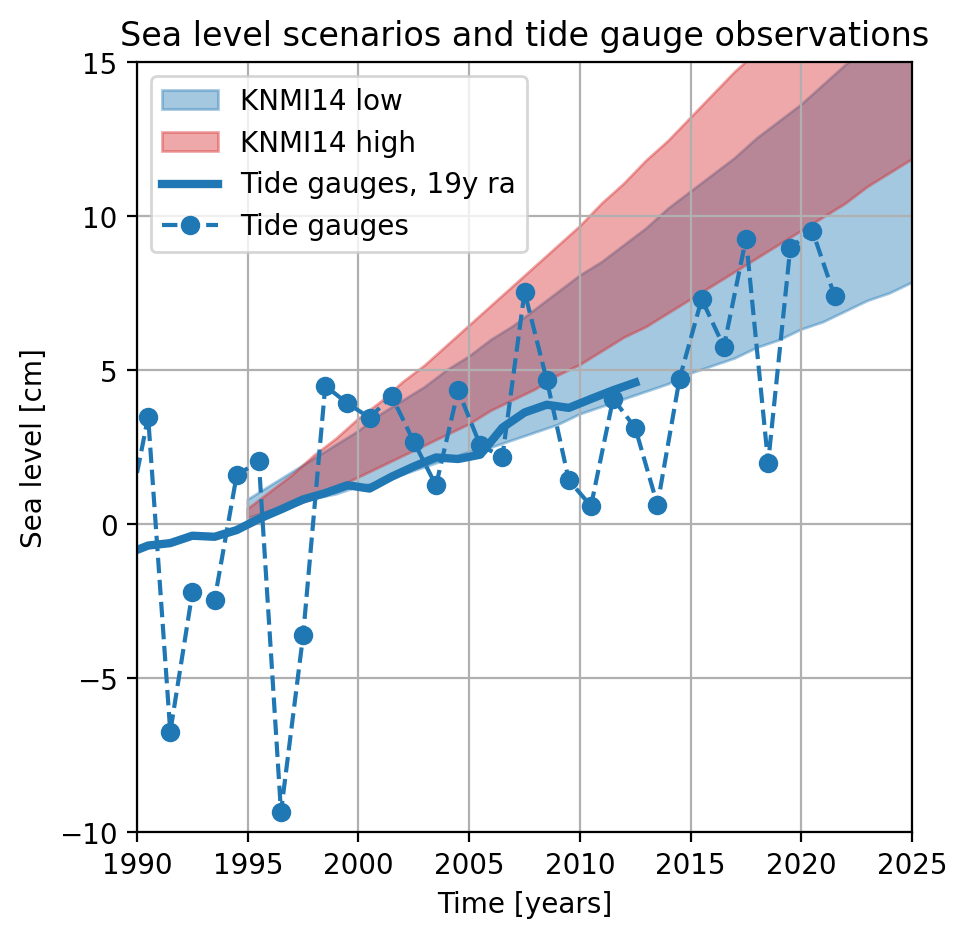

In [206]:
#Plot time series
fig, ax = plt.subplots(figsize=(5,5))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'], 
                KNMI14_df['low_95_sub'], color='tab:blue',alpha=0.4,
               label='KNMI14 low')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'], 
                KNMI14_df['high_95_sub'], color='tab:red',alpha=0.4,
               label='KNMI14 high')

ax.plot(tg_19ra - ref, '-', color='tab:blue', label='Tide gauges, 19y ra', linewidth=3)
ax.plot(budget_tg_df['Obs'] - ref, 'o--', color='tab:blue', label='Tide gauges')

ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('Time [years]')
plt.ylabel('Sea level [cm]')
plt.title('Sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig('./figures/CompObsScen_KNMI14.pdf', dpi=150)

### Check the difference between KNMI14 with and without the polynomial fit

In [188]:
KNMI14_polyfit_df = read_knmi14(add_subsidence=0.037, polyfit=True)
KNMI14_raw_df = read_knmi14(add_subsidence=0.037, polyfit=False)

(-10.0, 15.0)

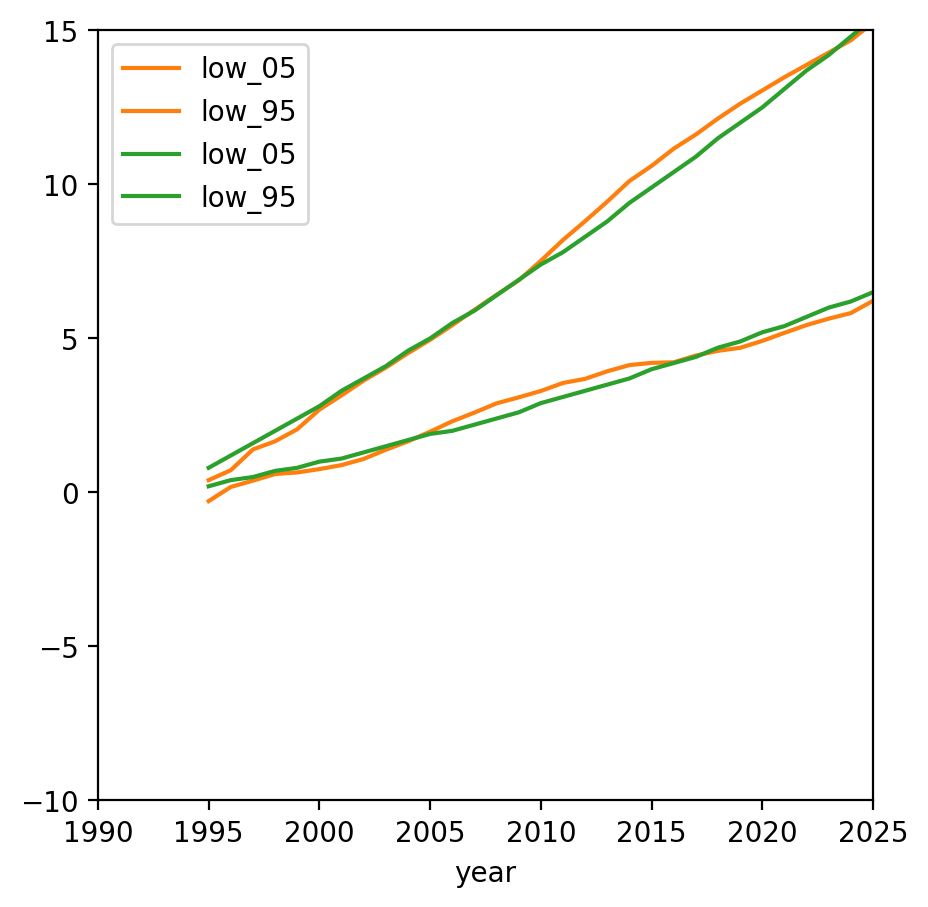

In [189]:
fig, ax = plt.subplots(figsize=(5,5))

KNMI14_raw_df[['low_05', 'low_95']].plot(color='tab:orange', ax=ax)
KNMI14_polyfit_df[['low_05', 'low_95']].plot(color='tab:green', ax=ax)

ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])

### Compare with a budget

In [190]:
def compute_linear_trend(se):
    """Returns the linear trend in mm/yr of a pandas series of sea level in cm"""
    
    se = se*10 # Convert from cm to mm
    lin_trend = linregress(se.index, se).slope
    
    return lin_trend

In [191]:
budget_tg_rate_df = budget_tg_df.loc[1995:2021].apply(lambda x: compute_linear_trend(x))
budget_alti_rate_df = budget_alti_df.loc[1995:2021].apply(lambda x: compute_linear_trend(x))


In [200]:
def comp_budget(sp, ep, sce, budget):
    '''Make a dataframe that can easily be used to make a bar chart'''

    if sce == 'low':
        KNMI14_sce = KNMI14_low_df
        rcp_scen = 'ssp245'
        KNMIsig_sce = KNMI23_ssp245_v1_df
        KNMI23_sce = KNMI23_ssp245_df
        
    elif sce == 'high':
        KNMI14_sce = KNMI14_high_df
        rcp_scen = 'ssp585'
        KNMIsig_sce = KNMI23_ssp585_v1_df
        KNMI23_sce = KNMI23_ssp585_df

    budget_rate = budget.loc[sp:ep].apply(lambda x: compute_linear_trend(x))

    budget_LocOcean = (budget_rate['LocSteric'] + budget_rate['Nodal'] + 
                       budget_rate['Wind'] +  budget_rate['Pressure'])
    
    KNMI14_rate = KNMI14_sce.loc[sp:ep].apply(lambda x: compute_linear_trend(x))
    KNMIsig_rate = KNMIsig_sce.loc[sp:ep].apply(lambda x: compute_linear_trend(x))
    KNMI23_rate = KNMI23_sce.loc[sp:ep].apply(lambda x: compute_linear_trend(x))

    # Build a new dataframe for comparison purposes:
    index = ['Total', 'Ocean', 'Glaciers', 'Antarctica', 
             'Greenland', 'Land water', 'GIA']

    obs_budget = [budget_rate['Total'], budget_LocOcean + budget_rate['GloSteric'],
                  budget_rate['Glaciers'], budget_rate['Antarctica'], 
                  budget_rate['Greenland'], budget_rate['TWS'], budget_rate['GIA']]
    
    KNMI23_scen = [KNMI23_rate['Total'], 
                   KNMI23_rate['Ocean Dynamic Sea Level'] + KNMI23_rate['Global steric'], 
                   KNMI23_rate['Glaciers'],
                   KNMI23_rate['Antarctica'], 
                   KNMI23_rate['Greenland'],
                   KNMI23_rate['Landwater'],
                   KNMI23_rate['GIA']]
    
    KNMIsig_scen = [KNMIsig_rate['Total']+0.45, 
                KNMIsig_rate['Local ocean'] + KNMI23_rate['Global steric'], 
                KNMIsig_rate['Glaciers'],
                KNMIsig_rate['sum anta.'], 
                KNMIsig_rate['Greenland SMB'] + KNMIsig_rate['Greenland dynamics'],
                KNMIsig_rate['Landwater'],
                0.45]
    
    KNMI14_scen = [KNMI14_rate['total']+subs_knmi14*10, 
                   KNMI14_rate['steric'], 
                   KNMI14_rate['gic'], 
                   KNMI14_rate['smb_aa'] + KNMI14_rate['dyn_aa'],
                   KNMI14_rate['smb_gre'] + KNMI14_rate['dyn_gre'],
                   KNMI14_rate['groundw'], 
                   subs_knmi14*10]
    
    comp_df = pd.DataFrame({'Observed budget': obs_budget,
                            f'KNMI23 {rcp_scen}': KNMI23_scen,
                            f'KS21 {rcp_scen}': KNMIsig_scen,
                            f'KNMI14 {sce} scenario': KNMI14_scen},
                           index=index)
    return comp_df

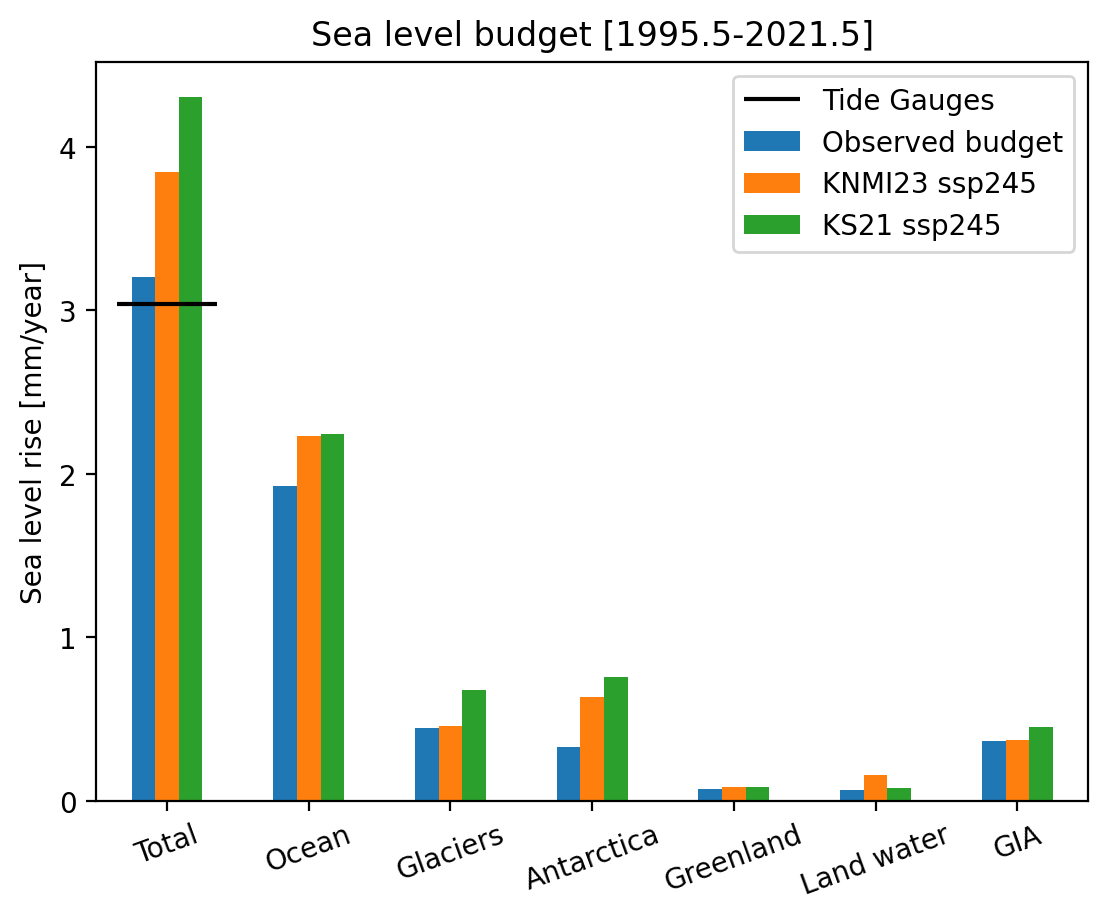

In [201]:
sp = 1995.5
ep = 2021.5

budget_df = budget_tg_df

sce = 'low' # 'low' or 'high'
comp_df = comp_budget(sp, ep, sce, budget_df)
obs_rate = compute_linear_trend(budget_df['Obs'].loc[sp:ep])

ax = comp_df.loc[:, comp_df.columns != 'KNMI14 low scenario'].plot.bar(rot=20)
ax.hlines(y=obs_rate, xmin=-0.35, xmax=0.35, color='black', label='Tide Gauges')

#ax.set_ylim([0,4.2])
plt.legend()
plt.ylabel('Sea level rise [mm/year]')
plt.title(f'Sea level budget [{sp}-{ep}]' )

plt.savefig('./figures/CompBudgetProj.pdf', dpi=150)

In [202]:
sce = 'high' # 'low' or 'high'
comp_high_df = comp_budget(sp, ep, sce, budget_df)

comp_knmi_df = comp_df[['Observed budget','KNMI23 ssp245', 'KNMI14 low scenario']].copy()
comp_knmi_df['KNMI14 high scenario'] =  comp_high_df['KNMI14 high scenario']

In [203]:
comp_knmi_df

,Observed budget,KNMI23 ssp245,KNMI14 low scenario,KNMI14 high scenario
Total,3.201974,3.844201,3.890344,5.161830
Ocean,1.924154,2.231027,2.234566,3.212427
Glaciers,0.446951,0.457709,0.681656,0.887166
Antarctica,0.327198,0.637494,0.357667,0.293258
Greenland,0.069929,0.083292,0.065538,0.076437
Land water,0.065409,0.161113,0.288938,0.288938
GIA,0.368333,0.370000,0.370000,0.370000


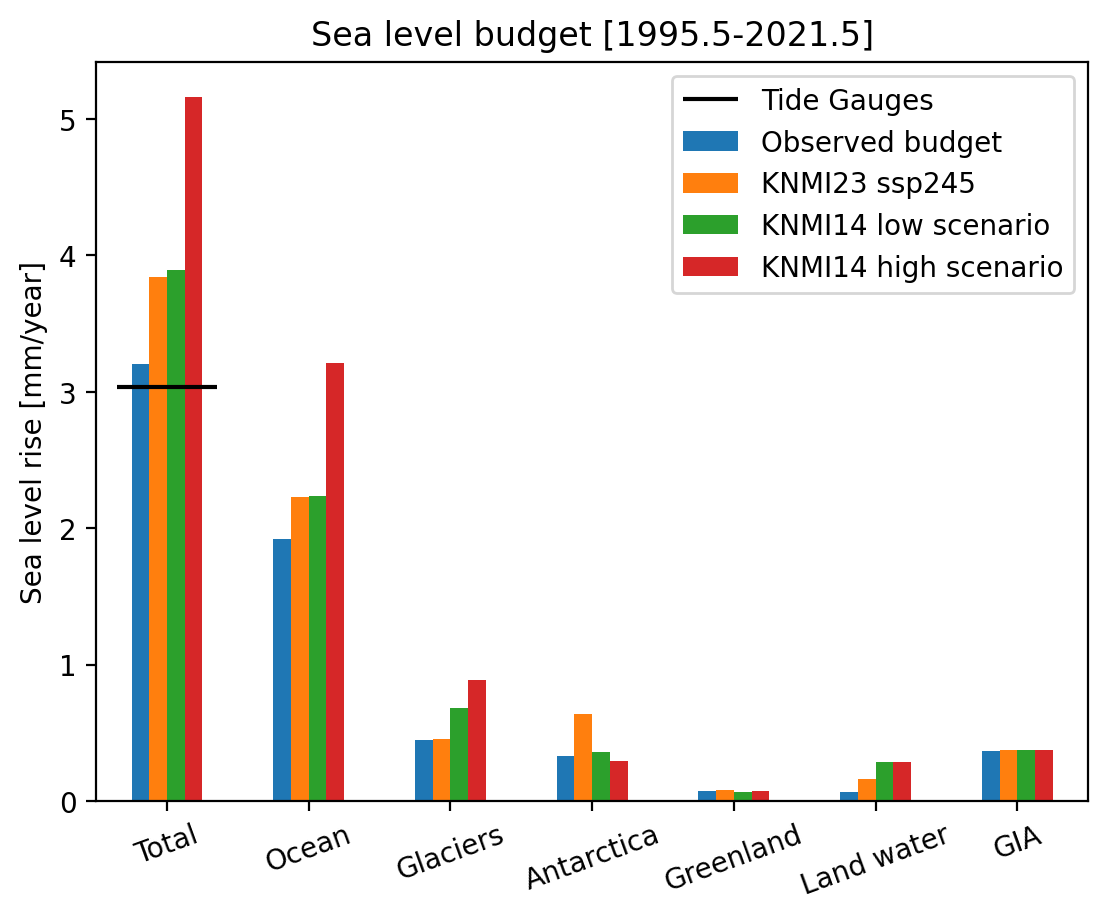

In [204]:
ax = comp_knmi_df.plot.bar(rot=20)
ax.hlines(y=obs_rate, xmin=-0.35, xmax=0.35, color='black', label='Tide Gauges')

#ax.set_ylim([0,4.2])
plt.legend()
plt.ylabel('Sea level rise [mm/year]')
plt.title(f'Sea level budget [{sp}-{ep}]' )

plt.savefig('./figures/CompBudgetProj_knmi14.pdf', dpi=150)

In [26]:
comp_df

,Observed budget,KNMI23 ssp245,KS21 ssp245,KNMI14 low scenario
Total,3.201974,3.844201,4.303897,3.970344
Ocean,1.924154,2.231027,2.241474,2.234566
Glaciers,0.446951,0.457709,0.679059,0.681656
Antarctica,0.327198,0.637494,0.755751,0.357667
Greenland,0.069929,0.083292,0.084203,0.065538
Land water,0.065409,0.161113,0.078982,0.288938
GIA,0.368333,0.370000,0.450000,0.450000


In [27]:
comp_df['Observed budget'].iloc[1:].sum()

3.2019742841526067

In [28]:
comp_df['KNMI23 ssp245'].iloc[1:].sum()

3.94063585695886

In [29]:
comp_df['KNMI14 low scenario'].iloc[1:].sum()

4.078365047899842

## Compare with a budget including more processes

- Separate local steric and wind

In [30]:
def comp_budget2(sp, ep, budget, rcp_scen):
    '''Make a dataframe that can easily be used to make a bar chart'''

    if rcp_scen == 'ssp245':
        KNMI23_sce = KNMI23_ssp245_df
    elif rcp_scen == 'ssp585':
        KNMI23_sce = KNMI23_ssp585_df

    budget_rate = budget.loc[sp:ep].apply(lambda x: compute_linear_trend(x))
    KNMI23_rate = KNMI23_sce.loc[sp:ep].apply(lambda x: compute_linear_trend(x))

    # Build a new dataframe for comparison purposes:
    index = ['Total', 'LocSteric', 'GloSteric','Glaciers', 'Antarctica', 
             'Greenland', 'Land water', 'GIA', 'Wind&IBE', 'Nodal']

    obs_budget = [budget_rate['Total'], 
                  budget_rate['LocSteric'], 
                  budget_rate['GloSteric'],
                  budget_rate['Glaciers'], 
                  budget_rate['Antarctica'], 
                  budget_rate['Greenland'], 
                  budget_rate['TWS'], 
                  budget_rate['GIA'],
                  budget_rate['Wind'] +  budget_rate['Pressure'], 
                  budget_rate['Nodal']]

    proj = [KNMI23_rate['Total'], 
            KNMI23_rate['Ocean Dynamic Sea Level'], 
            KNMI23_rate['Global steric'], 
            KNMI23_rate['Glaciers'],
            KNMI23_rate['Antarctica'], 
            KNMI23_rate['Greenland'],
            KNMI23_rate['Landwater'],
            KNMI23_rate['GIA'],
            0,
            0]
    
    comp_df = pd.DataFrame({'Budget': obs_budget,
                            f'KNMI23_{rcp_scen}': proj}, 
                            index=index)
    return comp_df

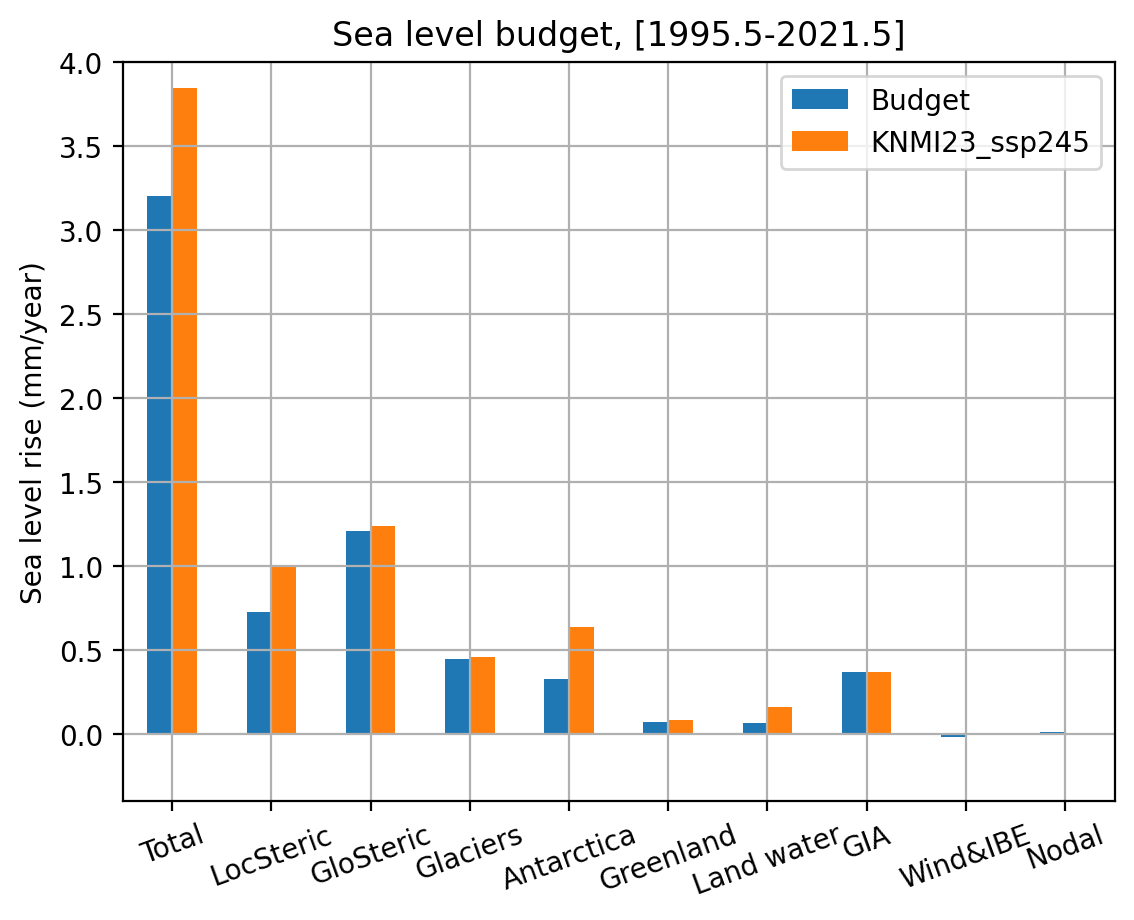

In [31]:
comp_df = comp_budget2(sp, ep, budget_df, 'ssp245')
ax = comp_df.plot.bar(rot=20)
ax.set_ylim([-0.4,4])

plt.ylabel('Sea level rise (mm/year)')
plt.title(f'Sea level budget, [{sp}-{ep}]' )
plt.grid();

plt.savefig(f'./figures/CompBudgetProj2.pdf', dpi=150)

In [32]:
comp_df

,Budget,KNMI23_ssp245
Total,3.201974,3.844201
LocSteric,0.724989,0.995081
GloSteric,1.207730,1.235946
Glaciers,0.446951,0.457709
Antarctica,0.327198,0.637494
Greenland,0.069929,0.083292
Land water,0.065409,0.161113
GIA,0.368333,0.370000
Wind&IBE,-0.016720,0.000000
Nodal,0.008154,0.000000


## Check the evolution of regional steric anomaly trend

In [33]:
def compute_trend_df(nby):
    'Use nby to compute the running linear regression'
    trend = []
    years = np.arange(1950,2021-nby+2)

    for y in years:
        sel = budget_df.loc[y+0.5:y+nby-1+0.5, 'LocSteric']
        reg = linregress(sel.index, sel)
        trend.append(reg.slope)

    trend_df = pd.DataFrame({f'TrendLocSteric_{nby}' : trend}, index=years+0.5)
    
    return trend_df

In [34]:
trend_27_df = compute_trend_df(27)
trend_29_df = compute_trend_df(29)

<AxesSubplot: >

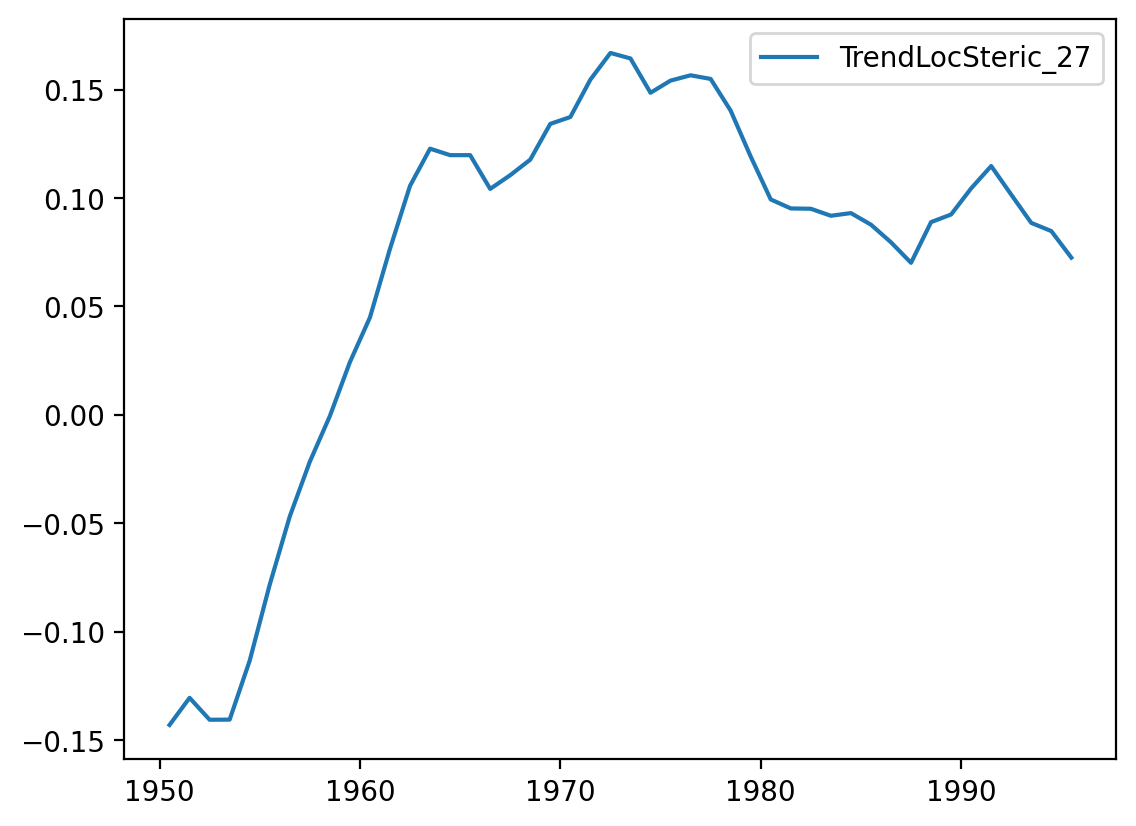

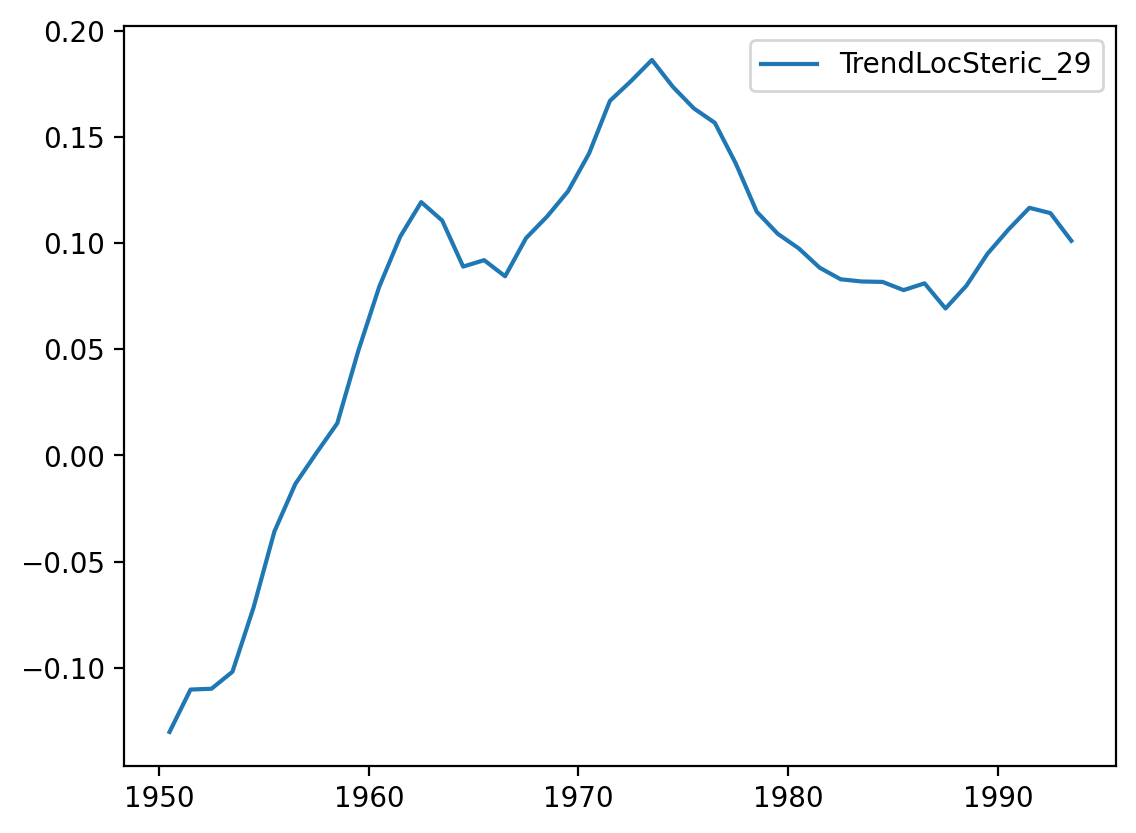

In [35]:
trend_27_df.plot()
trend_29_df.plot()

<AxesSubplot: xlabel='time'>

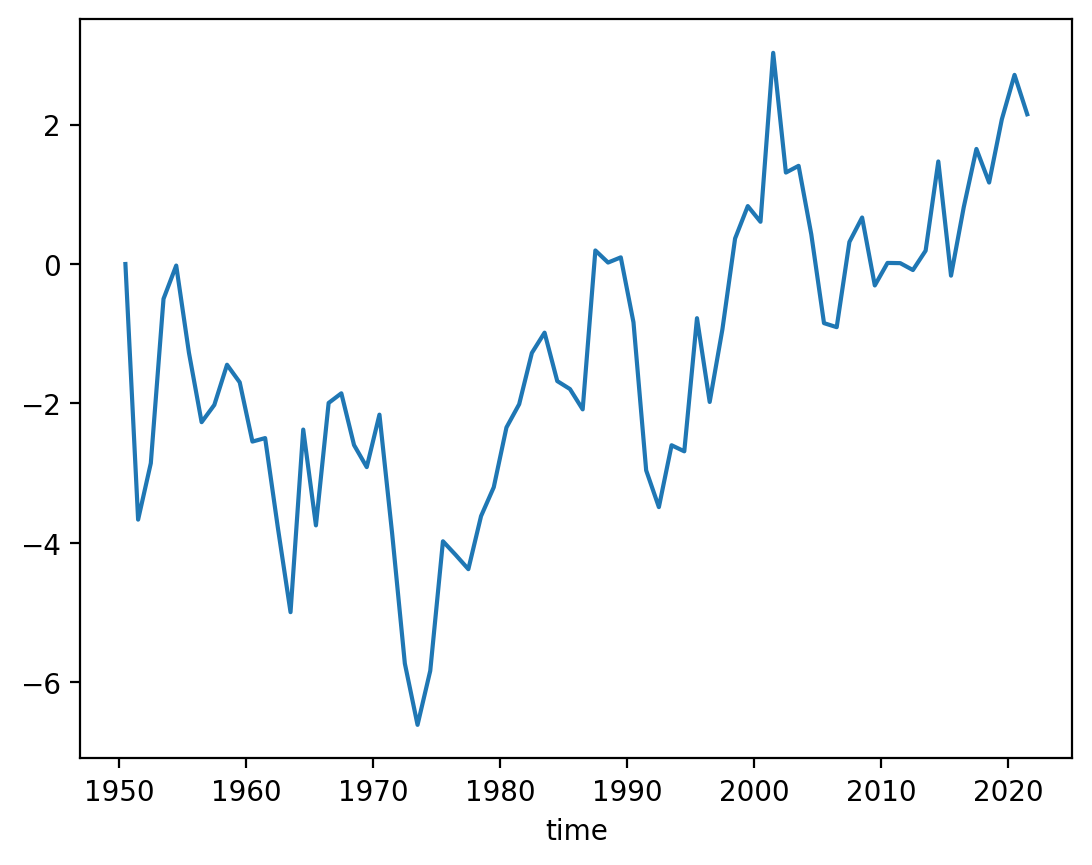

In [36]:
budget_df.LocSteric.plot()